In [ ]:
from mindspore import nn, ops, Tensor
from mindspore.common.initializer import LeCunNormal, Normal
import mindspore.numpy as mnp
from core.models import HEAQNN, FNN, DeepONet, QuanONet
from core.quantum_circuits import generate_simple_hamiltonian
import numpy as np
from scipy.interpolate import interp1d
    
branch_input_size = 100
trunk_input_size = 2
# model = FNN(branch_input_size=branch_input_size,
#             trunk_input_size=trunk_input_size,
#             output_size=1,
#             net_size=[4, 101])
# model = HEAQNN(num_qubits=5,
#                branch_input_size=branch_input_size,
#                trunk_input_size=trunk_input_size,
#                net_size=[40, 2],
#                ham = generate_simple_hamiltonian(5, upper_bound=5, lower_bound=-5),
#                scale_coeff=0.001,
#                if_trainable_freq=True)
model = QuanONet(
    num_qubits=5,                         # 增大量子比特
    branch_input_size=branch_input_size,
    trunk_input_size=trunk_input_size,
    net_size=[1, 2, 20, 2],                    # 增大第一维，常用于编码器参数或宽度
    ham=generate_simple_hamiltonian(5, 5, -5),
    scale_coeff=0.01,
    if_trainable_freq=True
)
pinn_model = PINN(model=model, trunk_input_size=trunk_input_size, operator='Advection')
# pinn_model = nn.WithLossCell(model, nn.MSELoss())
x = np.random.rand(32, branch_input_size + trunk_input_size).astype(np.float32)
branch = Tensor(x[:, :branch_input_size])
trunk = Tensor(x[:, branch_input_size:])
target = Tensor(np.random.rand(32, 1).astype(np.float32))
print("branch shape:", branch.shape)
print("trunk shape:", trunk.shape)
print("target shape:", target.shape)
print(pinn_model.construct((branch, trunk), target))
# print(pinn_model.net_first_grad_last_trunk_size((branch, trunk)))
# print(pinn_model.net_second_grad_last_trunk_size((branch, trunk)))
# print(pinn_model.construct_predict((branch, trunk)))

The number of encoder params is not enough for the input size.
branch shape: (32, 100)
trunk shape: (32, 2)
target shape: (32, 1)
0.6782944


In [16]:
from data_utils import ODE_encode, PDE_encode
from data_utils.data_generation import generate_Inverse_Operator_data, generate_Advection_Operator_data

# encode = PDE_encode
# train_branch_input, train_trunk_input, train_output, \
# test_branch_input, test_trunk_input, test_output = encode(
#     generate_Advection_Operator_data, num_train=1000, num_test=1000, num_points=100, train_sample_num=10, test_sample_num=100
# )

def f(x):
    return np.sin(2*np.pi * x)

def integral_f(x, t):
    return np.sin(2*np.pi * (x-t))
locations = np.linspace(0, 1, num=branch_input_size)
num_points = branch_input_size

x = Tensor(np.linspace(0, 1, num=num_points).astype(np.float32))
t = Tensor(np.linspace(0, 1, num=num_points).astype(np.float32))

trunk_input = mnp.zeros((0, 2))
x_repeat = ops.expand_dims(mnp.repeat(x, num_points, axis=0), 1)
t_tile = ops.expand_dims(mnp.tile(t, num_points), 1)
trunk_input_new = mnp.concatenate((x_repeat, t_tile), axis=1)
trunk_input_values = Tensor(mnp.concatenate((trunk_input, trunk_input_new), axis=0))
train_trunk_input_original = Tensor(trunk_input_values.astype(np.float32))
train_branch_input_original = Tensor(np.expand_dims(f(locations), axis=0).repeat(10000, axis=0).astype(np.float32))  # 在第二个轴上重复100次

train_output_original = Tensor(integral_f(trunk_input_values[:, 0], trunk_input_values[:, 1]).astype(np.float32)).reshape(-1, 1)

In [17]:
indices = np.random.choice(train_branch_input_original.shape[0], size=1000, replace=False)

train_branch_input = Tensor(train_branch_input_original.asnumpy()[indices, :])
train_trunk_input = Tensor(train_trunk_input_original.asnumpy()[indices, :])
train_output = Tensor(train_output_original.asnumpy()[indices, :])

In [18]:
optimizer = nn.Adam(pinn_model.trainable_params(), learning_rate=1e-5)

net_with_loss = pinn_model
train_net = nn.TrainOneStepCell(net_with_loss, optimizer)

for epoch in range(100):
    loss = train_net((train_branch_input, train_trunk_input), train_output)  # 添加 train_output 作为标签
    print(f"Epoch {epoch+1}, Loss: {loss.asnumpy()}")

Epoch 1, Loss: 0.5352349281311035
Epoch 2, Loss: 0.5346158742904663
Epoch 3, Loss: 0.5340016484260559
Epoch 4, Loss: 0.5333922505378723
Epoch 5, Loss: 0.5327878594398499
Epoch 6, Loss: 0.5321887135505676
Epoch 7, Loss: 0.5315946340560913
Epoch 8, Loss: 0.5310055017471313
Epoch 9, Loss: 0.530421793460846
Epoch 10, Loss: 0.5298444032669067
Epoch 11, Loss: 0.5292721390724182
Epoch 12, Loss: 0.5287051796913147
Epoch 13, Loss: 0.5281445384025574
Epoch 14, Loss: 0.5275920629501343
Epoch 15, Loss: 0.5270448923110962
Epoch 16, Loss: 0.526503324508667
Epoch 17, Loss: 0.5259679555892944
Epoch 18, Loss: 0.5254378914833069
Epoch 19, Loss: 0.5249128341674805
Epoch 20, Loss: 0.5243930816650391
Epoch 21, Loss: 0.5238789319992065
Epoch 22, Loss: 0.5233709216117859
Epoch 23, Loss: 0.522869348526001
Epoch 24, Loss: 0.5223751664161682
Epoch 25, Loss: 0.5218870639801025
Epoch 26, Loss: 0.5214048624038696
Epoch 27, Loss: 0.520927906036377
Epoch 28, Loss: 0.5204563140869141
Epoch 29, Loss: 0.519990622997283

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.50803727


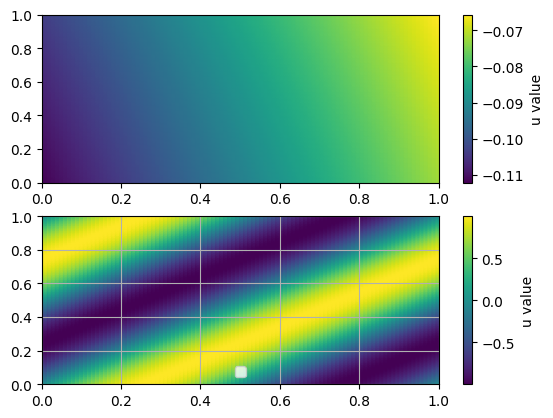

In [19]:
import numpy as np
import matplotlib.pyplot as plt

model_output = model((train_branch_input_original, train_trunk_input_original))  # 用底层 model 前向
x = train_trunk_input_original[:, 0].asnumpy()
t = train_trunk_input_original[:, 1].asnumpy()
u_pred = model_output.asnumpy().flatten()
u_exact = train_output_original.asnumpy().flatten()


print(pinn_model((train_branch_input_original, train_trunk_input_original), train_output_original).asnumpy())
# 可视化结果
plt.subplot(2, 1, 1)
plt.scatter(x, t, c=u_pred, cmap='viridis', s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar(label='u value')

plt.subplot(2, 1, 2)
plt.scatter(x, t, c=u_exact, cmap='viridis', s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar(label='u value')

plt.legend()
plt.grid()
plt.show()